# Spatial Group-wise Enhance

X. Li, X. Hu, and J, Yang, _Spatial Group-wise Enhance: Improving Semantic
Feature Learning in Convolutional Networks_, [arXiv:1905.09646 [cs.CV]](https://arxiv.org/abs/1905.09646) (2019).

## Introduction

Original Transformer for NLP:

A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. N. Gomez, L. Kaiser, I. Polosukhin, _Attention Is All You Need_, [arXiv:1706.03762 [cs.CL]](https://arxiv.org/abs/1706.03762) (2017).

Attention-like modules for Computer Vision:
- Squeeze-and-Excitation (SE) block, [arXiv:1709.01507 [cs.CV]](https://arxiv.org/abs/1709.01507) (2017).
- Bottleneck Attention Module (BAM), [arXiv:1807.06514 [cs.CV]](https://arxiv.org/abs/1807.06514) (2018).
- Convolutional Block Attention Module (CBAM), [arXiv:1807.06521 [cs.CV]](https://arxiv.org/abs/1807.06521) (2018).
- Gather-Excite, [arXiv:1810.12348 [cs.CV]](https://arxiv.org/abs/1810.12348) (2018).
- Selective Kernel (SK) unit, [arXiv:1903.06586 [cs.CV]](https://arxiv.org/abs/1903.06586) (2019).
- Global Context (GC) block, [arXiv:1904.11492 [cs.CV]](https://arxiv.org/abs/1904.11492) (2019).
- Spatial Group-wise Enhance (SGE), [arXiv:1905.09646 [cs.CV]](https://arxiv.org/abs/1905.09646) (2019).
- ResNeSt, [arXiv:2004.08955 [cs.CV]](https://arxiv.org/abs/2004.08955) (2020).

## Configuration

Imports

In [1]:
from collections import defaultdict
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

Configuration

In [2]:
NUM_GROUPS = 16

NUM_CLASSES = 10
EPOCHS = 40
BATCH_SIZE = 32

SAVE_PATH_ATTN = 'weights_attn.pkl'
SAVE_PATH_NO = 'weights_no.pkl'

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Dataset

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## Model

### ResNet

In [7]:
def init_linear(m, relu=True):
    if relu: nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
    else: nn.init.xavier_uniform_(m.weight)
    if m.bias is not None: nn.init.zeros_(m.bias)

In [8]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)
    
    def reset_parameters(self):
        init_linear(self[0])
        self[1].reset_parameters()

In [9]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, res_channels, stride):
        super().__init__(
            ConvBlock(in_channels, res_channels, 3, stride=stride),
            ConvBlock(res_channels, res_channels, 3, act=False)
        )

In [10]:
class Shortcut(nn.Sequential):
    def __init__(self, in_channels, res_channels, stride=1):
        layers = [] 
        if stride > 1:
            layers.append(nn.AvgPool2d(stride))
        if in_channels != res_channels:
            layers.append(ConvBlock(in_channels, res_channels, 1, act=False))
        super().__init__(*layers)

In [11]:
class AddReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU(inplace=True)
        self.gamma = nn.Parameter(torch.Tensor(1))

    def forward(self, x1, x2):
        out = x1 + self.gamma * x2
        return self.act(out)

    def reset_parameters(self):
        nn.init.zeros_(self.gamma)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, res_channels, residual, stride=1):
        super().__init__()
        self.shortcut = Shortcut(in_channels, res_channels, stride)
        self.residual = residual(in_channels, res_channels, stride)
        self.add = AddReLU()

    def forward(self, x):
        return self.add(self.shortcut(x), self.residual(x))

In [13]:
class ResidualBody(nn.Sequential):
    def __init__(self, in_channels, residual, repetitions, strides):
        layers = []
        res_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, res_channels, residual, stride))
                in_channels = res_channels
                stride = 1
            res_channels = res_channels * 2
        super().__init__(*layers)

In [14]:
class Stem(nn.Sequential):
    def __init__(self, channel_list=[3, 32, 32, 64], stride=2):
        layers = []
        for in_channels, out_channels in zip(channel_list, channel_list[1:]):
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            stride = 1
        super().__init__(*layers)

In [15]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, classes)
        )
    
    def reset_parameters(self):
        init_linear(self[2], relu=False)

In [16]:
class ResNet(nn.Sequential):
    def __init__(self, residual, repetitions, classes, strides=None):
        if not strides: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(stride=strides[0]),
            ResidualBody(64, residual, repetitions, strides[1:]),
            Head(64 * 2**(len(repetitions) - 1), classes)
        )
        self.reset_parameters()
    
    def _reset_children(self, module):
        for m in module.children():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
            else:
                self._reset_children(m)
    
    def reset_parameters(self):
        self._reset_children(self)

### Spatial Group-wise Enhance

Spatial Group-wise Enhance

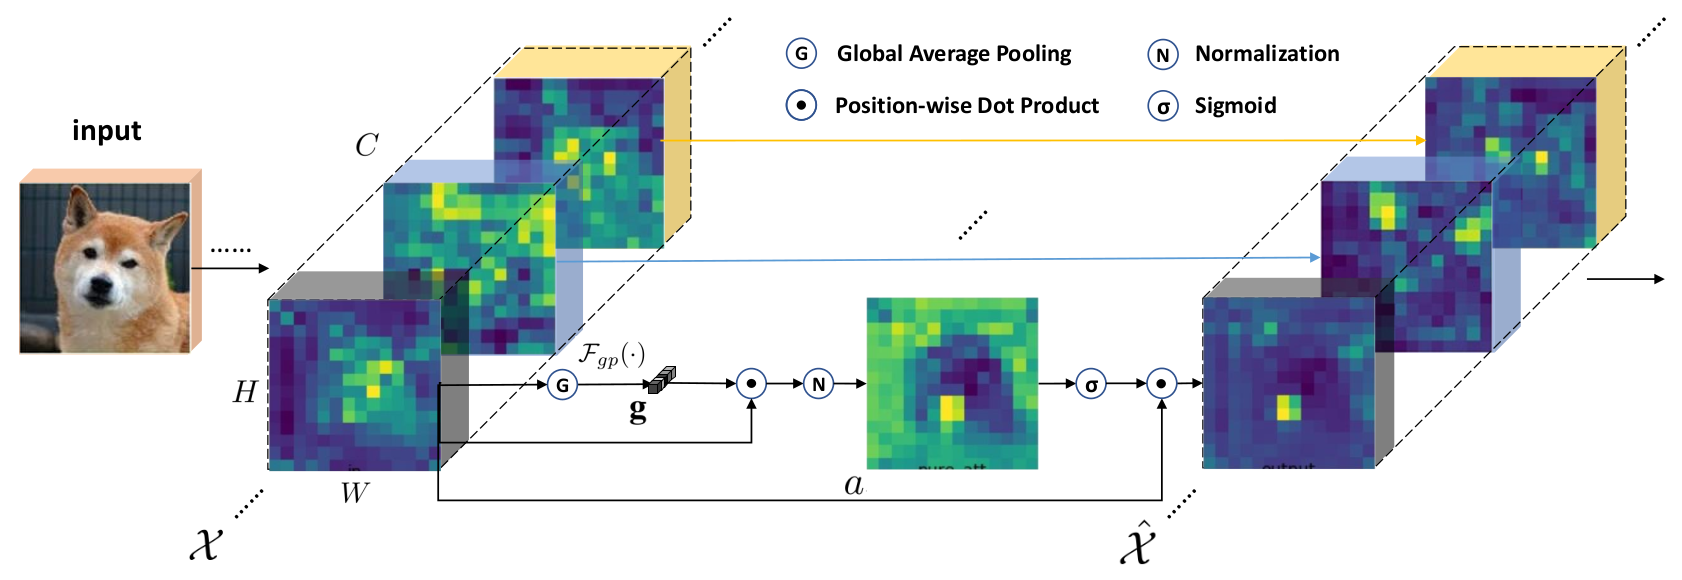

In [17]:
class SpatialGroupEnhance(nn.Module):
    def __init__(self, in_channels, groups=64):
        super().__init__()
        self.groups = groups
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.weight = nn.Parameter(torch.Tensor(1, groups, 1))
        self.bias = nn.Parameter(torch.Tensor(1, groups, 1))

    def forward(self, x):
        shape = x.size()
        b, c = shape[:2]
        bg = b * self.groups
        cg = c // self.groups
        x = x.view(bg, cg, -1)
        
        g = self.pool(x)
        ci = torch.bmm(g.transpose(1, 2), x).flatten(1) # scalar product
        
        #normalization
        std, mean = torch.std_mean(ci, dim=1, keepdim=True)
        cn = (ci - mean) / (std + 1e-7)
        
        a = cn.view(b, self.groups, -1)
        a = a * self.weight + self.bias
        a = a.view(bg, 1, -1)
        
        out = x * torch.sigmoid(a)
        out = out.view(*shape)
        return out
    
    def reset_parameters(self):
        # initially we initalize weight to zero to turn the attention mechanism off
        nn.init.zeros_(self.weight)
        nn.init.ones_(self.bias)

In [18]:
class BasicSGEResidual(BasicResidual):
    def __init__(self, in_channels, res_channels, stride):
        super().__init__(in_channels, res_channels, stride)
        self.add_module(str(len(self)), SpatialGroupEnhance(res_channels, groups=NUM_GROUPS))

## Training

### Training loop

In [19]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [20]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _plot(self, key, line_type='-', label=None):
        if not label: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot_train_val(self, key, x_is_batch=False, ylog=False, filename=None):
        fig = plt.figure()
        self.ax = fig.add_subplot(111)
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        if ylog: self.ax.set_yscale('log')
        self.ax.set_xlabel('batch' if x_is_batch else 'epoch')
        self.ax.set_ylabel(key)
        show_or_save(fig, filename)

In [21]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 epoch_scheduler=None, batch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epoch_scheduler = epoch_scheduler
        self.batch_scheduler = batch_scheduler
        self.history = History()
    
    
    def iterate(self, loader, backward_pass=False):
        total_loss = 0.0
        num_samples = 0
        num_correct = 0

        for X, Y in loader:
            X, Y = X.to(self.device), Y.to(self.device)
            Y_pred = self.model(X)
            batch_size = X.size(0)
            batch_loss = self.loss(Y_pred, Y)
            if backward_pass:
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                if self.batch_scheduler is not None:
                    self.batch_scheduler.step()
            
            Y_pred.detach_() # conserve memory
            labels_pred = torch.argmax(Y_pred, -1)
            total_loss += batch_size * batch_loss.item()
            num_correct += (labels_pred == Y).sum()
            num_samples += batch_size
    
        avg_loss = total_loss / num_samples
        accuracy = float(num_correct) / num_samples
        return avg_loss, accuracy
    
    
    def train(self):
        self.model.train()
        train_loss, train_acc = self.iterate(self.train_loader, backward_pass=True)
        print(f'train: loss {train_loss:.3f}, acc {train_acc:.3f}')
        self.history.append('train loss', train_loss)
        self.history.append('train acc', train_acc)

        
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss, val_acc = self.iterate(self.val_loader)
        print(f'val: loss {val_loss:.3f}, acc {val_acc:.3f}')
        self.history.append('val loss', val_loss)
        self.history.append('val acc', val_acc)


    def fit(self, epochs):
        for i in range(epochs):
            print(f'{i+1}/{epochs}')
            self.train()
            self.validate()
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()

### Start training

In [22]:
model_no = ResNet(BasicResidual, [2, 2, 2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2]).to(DEVICE)
model = ResNet(BasicSGEResidual, [2, 2, 2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2]).to(DEVICE)

In [20]:
loss = nn.CrossEntropyLoss()

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [25]:
learner = Learner(model, loss, optimizer, train_loader, val_loader, DEVICE)

In [26]:
learner.batch_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                                        steps_per_epoch=len(train_loader),
                                                        epochs=EPOCHS)

In [27]:
learner.fit(EPOCHS)

1/40
train: loss 1.373, acc 0.506
val: loss 1.041, acc 0.629
2/40
train: loss 0.936, acc 0.669
val: loss 1.060, acc 0.653
3/40
train: loss 0.751, acc 0.739
val: loss 0.847, acc 0.720
4/40
train: loss 0.665, acc 0.770
val: loss 0.624, acc 0.780
5/40
train: loss 0.594, acc 0.796
val: loss 0.610, acc 0.790
6/40
train: loss 0.548, acc 0.812
val: loss 0.637, acc 0.788
7/40
train: loss 0.515, acc 0.824
val: loss 0.666, acc 0.788
8/40
train: loss 0.493, acc 0.831
val: loss 0.674, acc 0.789
9/40
train: loss 0.471, acc 0.839
val: loss 0.501, acc 0.829
10/40
train: loss 0.452, acc 0.844
val: loss 0.607, acc 0.796
11/40
train: loss 0.431, acc 0.852
val: loss 0.450, acc 0.847
12/40
train: loss 0.411, acc 0.860
val: loss 0.452, acc 0.846
13/40
train: loss 0.394, acc 0.865
val: loss 0.387, acc 0.872
14/40
train: loss 0.371, acc 0.872
val: loss 0.519, acc 0.833
15/40
train: loss 0.353, acc 0.879
val: loss 0.415, acc 0.863
16/40
train: loss 0.340, acc 0.883
val: loss 0.461, acc 0.846
17/40
train: loss

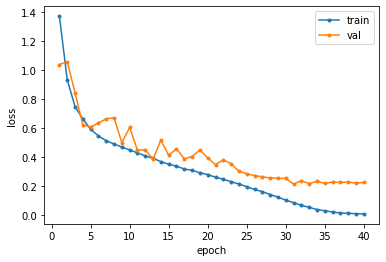

In [31]:
learner.history.plot_train_val('loss')

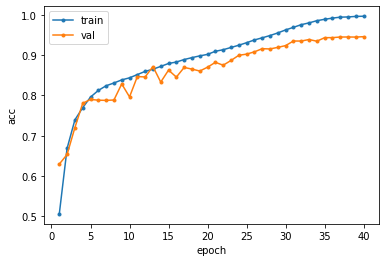

In [32]:
learner.history.plot_train_val('acc')

In [33]:
#torch.save(model_no.state_dict(), SAVE_PATH_NO)
torch.save(model.state_dict(), SAVE_PATH_ATTN)

## Testing

In [23]:
class ModelTester:
    def __init__(self, model):
        self.model = model
        self.handles = []
        self.output = None
    
    def _forward_hook(self, module, inp, output):
        self.output = output
    
    def register_hooks(self, num):
        self.delete_hooks()
        self.handles = []
        m = self.model[1][num].residual
        handle = m.register_forward_hook(self._forward_hook)
        self.handles.append(handle)
    
    def delete_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def diagnostic_run(self, X, num):
        self.register_hooks(num)

        self.model.eval()
        self.model(X.unsqueeze(0))
        self.output = self.output.detach().squeeze(0).cpu()
        self.groups = self.output.chunk(NUM_GROUPS)

        self.delete_hooks()
    
    def show_group(self, grp_num):
        act = self.groups[grp_num].norm(p=2, dim=0)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_axis_off()
        ax.matshow(act.numpy())
        plt.show()

In [24]:
def show_image(X):
    img = np.moveaxis(X.cpu().numpy(), 0, -1)
    img = np.uint8(img * 255)
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.matshow(img)
    plt.show()

In [25]:
model_no.load_state_dict(torch.load(SAVE_PATH_NO))

<All keys matched successfully>

In [27]:
model.load_state_dict(torch.load(SAVE_PATH_ATTN))

<All keys matched successfully>

In [37]:
model_no.eval();
model.eval();

In [29]:
tester_no = ModelTester(model_no)
tester = ModelTester(model)

In [71]:
X_test, Y_test = test_dset[4]
X_test = X_test.to(DEVICE)

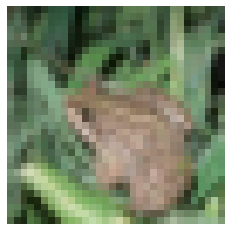

In [72]:
show_image(X_test)

In [80]:
tester_no.diagnostic_run(X_test, 3)
tester.diagnostic_run(X_test, 3)

With SGE


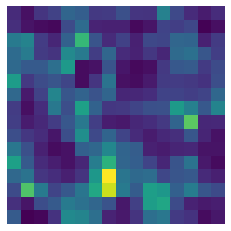

Without SGE


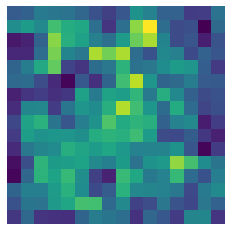

In [102]:
grp_num = 1
print('With SGE')
tester.show_group(grp_num)
print('Without SGE')
tester_no.show_group(grp_num)